In [1]:
!pip install xgboost

In [7]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.2 MB/s eta 0:00:08
   -- ------------------------------------- 0.5/9.6 MB 1.2 MB/s eta 0:00:08
   --- ------------------------------------ 0.8/9.6 MB 1.2 MB/s eta 0:00:08
   ---- ----------------------------------- 1.0/9.6 MB 1.2 MB/s eta 0:00:08
   ----- ---------------------------------- 1.3/9.6 MB 1.2 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.6 MB 1.1 MB/s eta 0:00:08
   ------- -------------------------------- 1.8/9.6 MB 1.2 MB/s eta 0:00:07
   -------- ------------------------------- 2.1/9.6 MB 1.2 MB/s eta 0:00:07
   --------- ------------------------------ 2.4/9.6 MB 1.2 MB/s eta 0:00:07
   ---------- ----------------------------- 2.6/9.6 MB 1.2 MB/s eta 0:00:06
   ----------- ---------------------------- 2.9/9.6 MB 1.2 MB/s eta 0:00:06
   ------------- ---------

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [32]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')  # Contains future dates for forecasting
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

train_merged = pd.merge(train_df, stores_df, on='Store', how='left')
train_merged = pd.merge(train_merged, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

test_merged = pd.merge(test_df, stores_df, on='Store', how='left')
test_merged = pd.merge(test_merged, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

train_merged['Date'] = pd.to_datetime(train_merged['Date'])
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

print("Training data shape:", train_merged.shape)
print("Test data shape:", test_merged.shape)

Training data shape: (421570, 16)
Test data shape: (115064, 15)


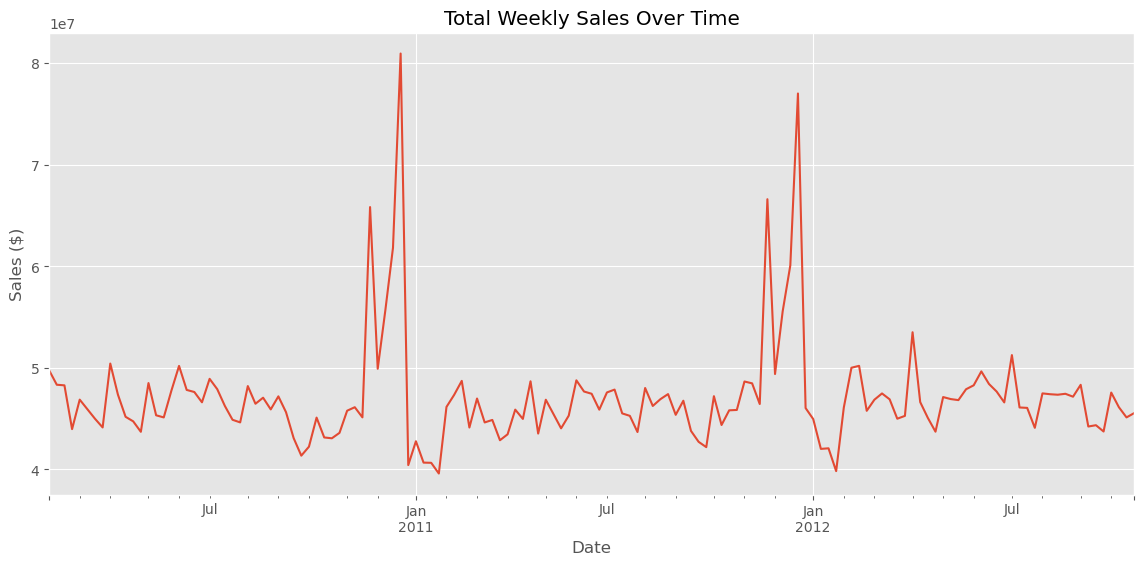

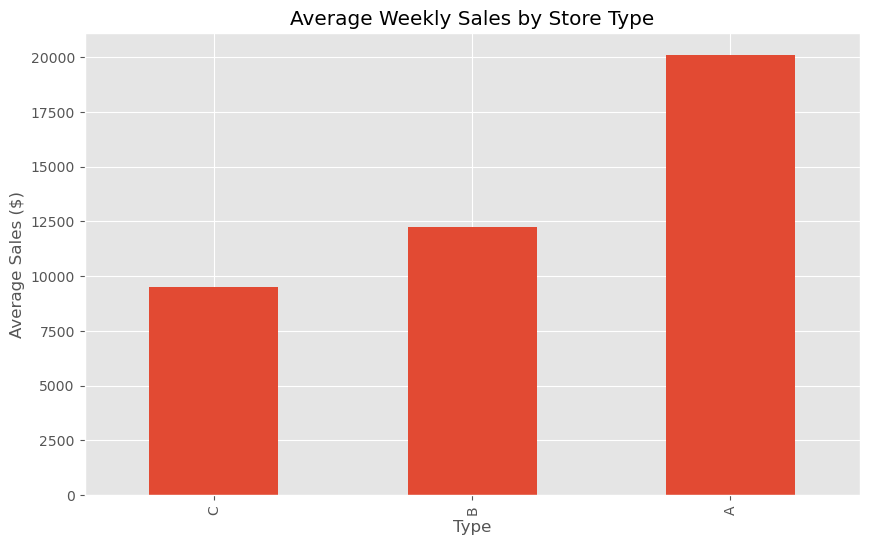


Holiday vs Non-Holiday Sales:
IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64


In [13]:
plt.figure(figsize=(14, 6))
train_merged.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title('Total Weekly Sales Over Time')
plt.ylabel('Sales ($)')
plt.xlabel('Date')
plt.show()

plt.figure(figsize=(10, 6))
train_merged.groupby('Type')['Weekly_Sales'].mean().sort_values().plot(kind='bar')
plt.title('Average Weekly Sales by Store Type')
plt.ylabel('Average Sales ($)')
plt.show()

holiday_sales = train_merged.groupby('IsHoliday')['Weekly_Sales'].mean()
print("\nHoliday vs Non-Holiday Sales:")
print(holiday_sales)

Starting feature engineering...

Creating time features...
Creating lag features...
Calculating rolling statistics...
Handling missing values...

Feature engineering completed! Verification:
Final training shape: (421570, 27)

New features sample:


,Date,Store,Dept,Year,Month,Week,lag_1,lag_52,rolling_mean_4
0,2010-02-05,1,1,2010,2,5,0.00,0.0,24924.500000
1,2010-02-12,1,1,2010,2,6,24924.50,0.0,35481.995000
2,2010-02-19,1,1,2010,2,7,46039.49,0.0,37519.846667



Missing values check:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
dtype: int64


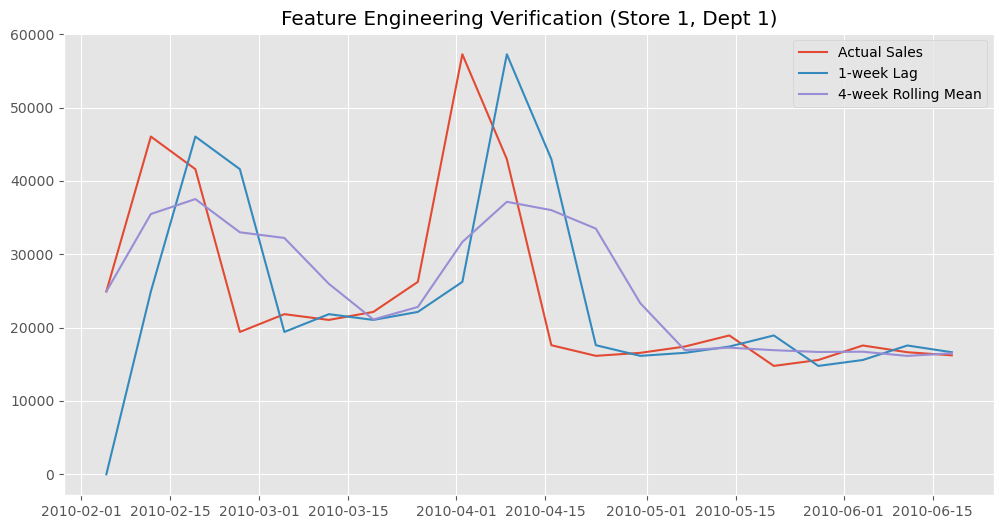

In [24]:
def create_features(df):
    # Time-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    
    # Encode categoricals
    le = LabelEncoder()
    df['Type'] = le.fit_transform(df['Type'])
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    
    return df

print("Starting feature engineering...")

print("\nCreating time features...")
train_merged = create_features(train_merged)
test_merged = create_features(test_merged)

print("Creating lag features...")
train_merged.sort_values(['Store', 'Dept', 'Date'], inplace=True)
for lag in [1, 2, 3, 4, 52]:  # 1-4 weeks + 1 year lag
    train_merged[f'lag_{lag}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

print("Calculating rolling statistics...")
train_merged['rolling_mean_4'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean())
train_merged['rolling_std_4'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).std())

print("Handling missing values...")
train_merged.fillna(0, inplace=True)
train_merged.dropna(subset=['Weekly_Sales'], inplace=True)

print("\nFeature engineering completed! Verification:")
print(f"Final training shape: {train_merged.shape}")
print("\nNew features sample:")
display(train_merged[['Date', 'Store', 'Dept', 'Year', 'Month', 'Week', 
                     'lag_1', 'lag_52', 'rolling_mean_4']].head(3))

print("\nMissing values check:")
print(train_merged.isnull().sum().sort_values(ascending=False).head(10))

sample = train_merged[(train_merged['Store']==1) & (train_merged['Dept']==1)].head(20)
plt.figure(figsize=(12, 6))
plt.plot(sample['Date'], sample['Weekly_Sales'], label='Actual Sales')
plt.plot(sample['Date'], sample['lag_1'], label='1-week Lag')
plt.plot(sample['Date'], sample['rolling_mean_4'], label='4-week Rolling Mean')
plt.title('Feature Engineering Verification (Store 1, Dept 1)')
plt.legend()
plt.show()

In [17]:
def prepare_test_features(test_data, train_data):
    test_data = test_data.copy()
    
    for idx, row in test_data.iterrows():
        store, dept = row['Store'], row['Dept']
        last_values = train_data[(train_data['Store'] == store) & 
                               (train_data['Dept'] == dept)].sort_values('Date').tail(52)
        
        # Add lag features
        for i, lag in enumerate([1, 2, 3, 4, 52]):
            if len(last_values) >= lag:
                test_data.loc[idx, f'lag_{lag}'] = last_values['Weekly_Sales'].iloc[-lag]
            else:
                test_data.loc[idx, f'lag_{lag}'] = 0
        

        if len(last_values) >= 4:
            test_data.loc[idx, 'rolling_mean_4'] = last_values['Weekly_Sales'].tail(4).mean()
            test_data.loc[idx, 'rolling_std_4'] = last_values['Weekly_Sales'].tail(4).std()
        else:
            test_data.loc[idx, 'rolling_mean_4'] = 0
            test_data.loc[idx, 'rolling_std_4'] = 0
    
    return test_data

test_processed = prepare_test_features(test_merged, train_merged)

<Figure size 1200x800 with 0 Axes>

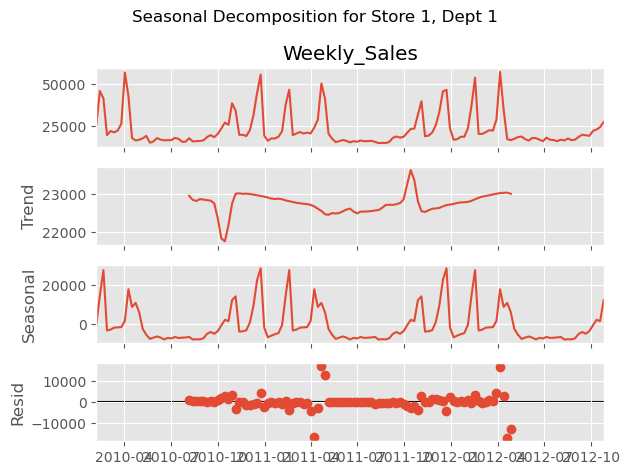

In [18]:
sample_store = train_merged[(train_merged['Store'] == 1) & (train_merged['Dept'] == 1)].set_index('Date')
decomposition = seasonal_decompose(sample_store['Weekly_Sales'], model='additive', period=52)

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition for Store 1, Dept 1')
plt.tight_layout()
plt.show()

In [28]:
features = ['Store', 'Dept', 'IsHoliday', 'Size', 'Type', 'Year', 'Month', 'Week', 'Day',
            'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
            'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_52',
            'rolling_mean_4', 'rolling_std_4']

cutoff_date = train_merged['Date'].max() - pd.DateOffset(weeks=12)
train = train_merged[train_merged['Date'] <= cutoff_date]
val = train_merged[train_merged['Date'] > cutoff_date]

X_train, y_train = train[features], train['Weekly_Sales']
X_val, y_val = val[features], val['Weekly_Sales']

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,  # Moved inside constructor
    eval_metric='rmse'  # Added evaluation metric
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=10
)

val_pred = xgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'\nValidation RMSE: ${val_rmse:,.2f}')

[0]	validation_0-rmse:20824.46186
[10]	validation_0-rmse:12603.44400
[20]	validation_0-rmse:7735.26961
[30]	validation_0-rmse:4864.03940
[40]	validation_0-rmse:3226.45675
[50]	validation_0-rmse:2326.59130
[60]	validation_0-rmse:1861.10677
[70]	validation_0-rmse:1634.59254
[80]	validation_0-rmse:1510.19868
[90]	validation_0-rmse:1445.18578
[100]	validation_0-rmse:1406.95782
[110]	validation_0-rmse:1379.03390
[120]	validation_0-rmse:1357.14087
[130]	validation_0-rmse:1339.69592
[140]	validation_0-rmse:1329.13161
[150]	validation_0-rmse:1321.05825
[160]	validation_0-rmse:1315.39697
[170]	validation_0-rmse:1309.85069
[180]	validation_0-rmse:1302.92394
[190]	validation_0-rmse:1293.56919
[200]	validation_0-rmse:1289.06917
[210]	validation_0-rmse:1281.36630
[220]	validation_0-rmse:1274.72834
[230]	validation_0-rmse:1269.49437
[240]	validation_0-rmse:1263.34232
[250]	validation_0-rmse:1257.40106
[260]	validation_0-rmse:1252.97334
[270]	validation_0-rmse:1249.17945
[280]	validation_0-rmse:1244.

<Figure size 1200x800 with 0 Axes>

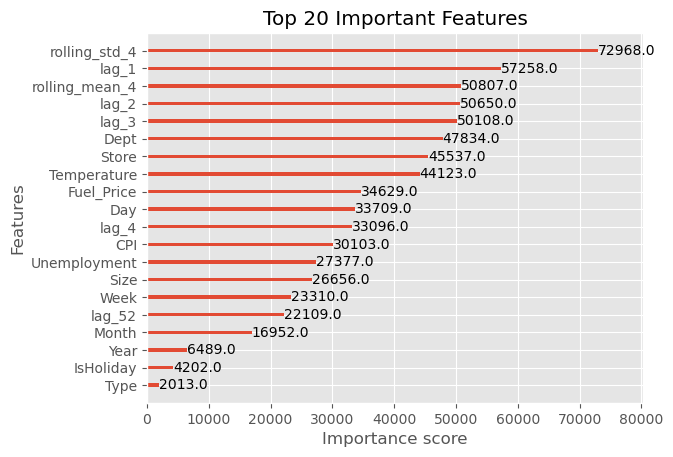

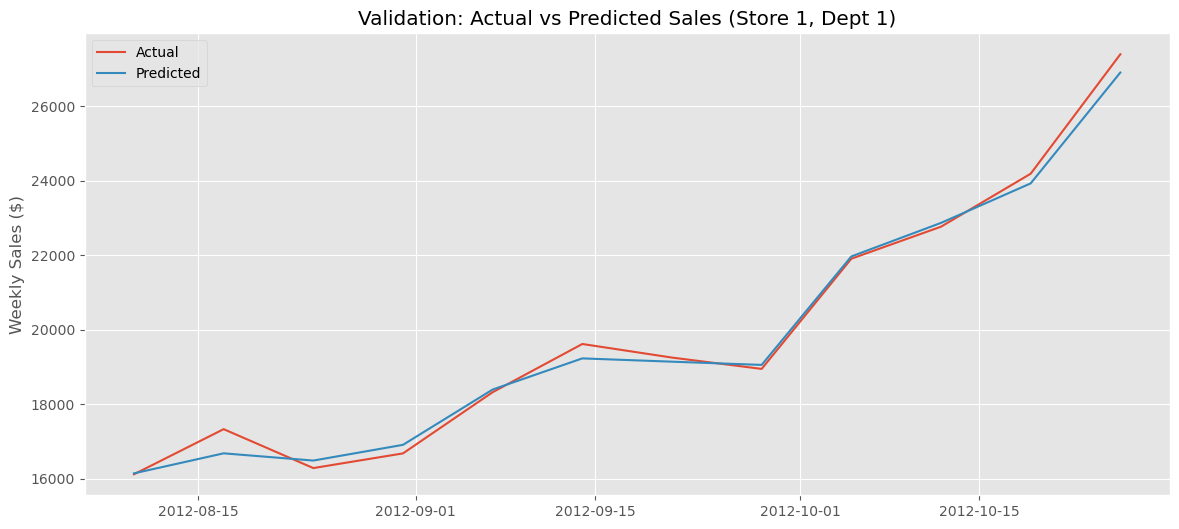

In [30]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Top 20 Important Features')
plt.show()

val['Predicted'] = val_pred
sample_val = val[(val['Store'] == 1) & (val['Dept'] == 1)]

plt.figure(figsize=(14, 6))
plt.plot(sample_val['Date'], sample_val['Weekly_Sales'], label='Actual')
plt.plot(sample_val['Date'], sample_val['Predicted'], label='Predicted')
plt.title('Validation: Actual vs Predicted Sales (Store 1, Dept 1)')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.show()

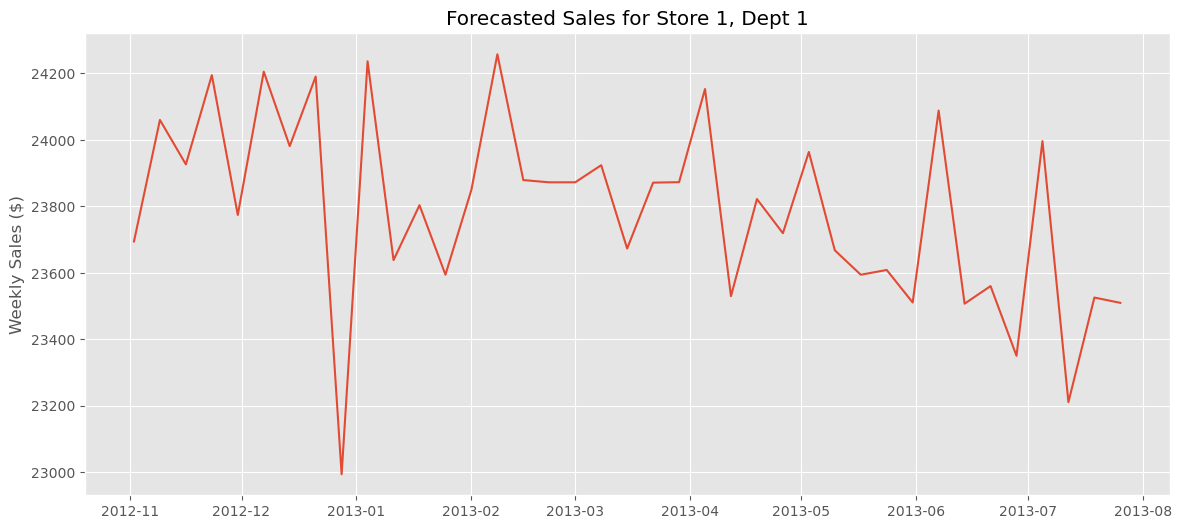

Predictions saved to 'walmart_sales_predictions.csv'


In [26]:
xgb_model.fit(train_merged[features], train_merged['Weekly_Sales'])

test_predictions = xgb_model.predict(test_processed[features])

submission = test_processed[['Store', 'Dept', 'Date']].copy()
submission['Weekly_Sales'] = test_predictions

sample_forecast = submission[(submission['Store'] == 1) & (submission['Dept'] == 1)]

plt.figure(figsize=(14, 6))
plt.plot(sample_forecast['Date'], sample_forecast['Weekly_Sales'])
plt.title('Forecasted Sales for Store 1, Dept 1')
plt.ylabel('Weekly Sales ($)')
plt.show()

submission.to_csv('walmart_sales_predictions.csv', index=False)
print("Predictions saved to 'walmart_sales_predictions.csv'")